# Simple Neural Network using only Numpy (1 layer w/ 1 neuron)

In [5]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['ggplot'])
import time
from IPython.display import clear_output

## Load the dataset (CIFAR-10)
Into numpy arrays X and Y.

(CIFAR-10 website: https://www.cs.toronto.edu/~kriz/cifar.html)

<img src="cifar10examples2.png" width="500" height="700">

In [6]:
import pickle

In [7]:
"""def unpickle(data_file):
    # Function for a single data file.
    with open(data_file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict"""

"def unpickle(data_file):\n    with open(data_file, 'rb') as fo:\n        data_dict = pickle.load(fo, encoding='bytes')\n    return data_dict"

In [8]:
def unpickle(data_folder, data_files):
    # Function for multiple data files.
    data_dict = {}
    for file in data_files:
        with open(data_folder + "/" + file, 'rb') as f:
            if len(data_dict) == 0:
                data_dict = pickle.load(f, encoding="bytes")
            else:
                temp_dict = pickle.load(f, encoding="bytes")
                data_dict[b'data'] = np.append(data_dict[b'data'], temp_dict[b'data'], axis=0)
                data_dict[b'labels'] = np.append(data_dict[b'labels'], temp_dict[b'labels'], axis=0)
    return data_dict

In [9]:
train_dict = unpickle("./data", ["data_batch_1", "data_batch_2"])#, "data_batch_3", "data_batch_4", "data_batch_5"])
X_train = train_dict[b'data'] / 255
y_train = np.asarray(train_dict[b'labels'])
Y_train = np.eye(np.max(y_train)+1)[y_train]    # Y is one-hot-encoding of y.

test_dict = unpickle("./data", ["test_batch"])
X_test = test_dict[b'data'] / 255
y_test = np.asarray(test_dict[b'labels'])
Y_test = np.eye(np.max(y_test)+1)[y_test]    # Y is one-hot-encoding of y.

In [10]:
X_train.shape    # 32x32x3 = 3072

(20000, 3072)

In [11]:
Y_train.shape

(20000, 10)

In [12]:
Y_train[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

## Initializing hyperparameters
Batch size, number of epochs, (cyclical) learning rate, L2 regularization rate (lambda)...

In [14]:
n_batch = 100     # Batch size.
n_epochs = 10     # Number of epochs.
eta = 1e-3        # Learning rate.
# Better to use Cyclical Learning Rate, but not implemented at the moment:
#eta_min = 1e-5   # The minimum...
#eta_max = 1e-1   # ...and the maximum learning rate.
lambd = 0.1       # L2 Regularization

## Initialize model parameters
Weights and bias vectors.

In [16]:
d = X_train.shape[1]        # Number of features (3072).
K = Y_train.shape[1]        # Number of classes/targets (10).
N_train = X_train.shape[0]  # Number of training datapoints.
N_test = X_test.shape[0]    # Number of test datapoints.

# Weights and bias sampled from normal (Gaussian) distribution
# with mean = 0 and std deviation = 0.1:
W = np.random.normal(0, 0.01, (K, d))    # W has dimensions Kxd, ie 10x3072.
b = np.random.normal(0, 0.01, (K))       # b has dimensions Kx1, ie 10x1.

## Calculate cost & accuracy baselines
For un-trained parameters W and b.

In [17]:
start_time = time.time()
# To keep track of costs and accuracies throughout the fit:
costs_train = []
costs_test = []
accs_train = []
accs_test = []

print("1: --- %s seconds ---" % (time.time() - start_time))
# Calculate the costs and accuracies with initial W and b - to get baseline:
# Accuracy on training set:
train_logits = np.dot(X_train, W.T) + b
exp_p = np.exp(train_logits - np.max(train_logits))
train_probs = (exp_p.T / np.sum(exp_p, axis=1)).T
train_accuracy = 100 * len(np.where(np.argmax(train_probs, axis=1) == y_train)[0]) / y_train.shape[0]

print("2: --- %s seconds ---" % (time.time() - start_time))
# Cost on training dataset:
log_likelihood = -(np.inner(Y_train, np.log(train_probs)))    # Standard Loss = -Y * log(Predictions)
log_likelihood = np.diag(log_likelihood)
train_loss = np.sum(log_likelihood) / N_train
train_cost = train_loss + lambd*(np.sum(W)**2)

print("3: --- %s seconds ---" % (time.time() - start_time))
# Accuracy on training set:
test_logits = np.dot(X_test, W.T) + b
exp_p = np.exp(test_logits - np.max(test_logits))
test_probs = (exp_p.T / np.sum(exp_p, axis=1)).T
test_accuracy = 100 * len(np.where(np.argmax(test_probs, axis=1) == y_test)[0]) / y_test.shape[0]

print("4: --- %s seconds ---" % (time.time() - start_time))
# Cost on training dataset:
log_likelihood = -(np.inner(Y_test, np.log(test_probs)))    # Standard Loss = -Y * log(Predictions)
log_likelihood = np.diag(log_likelihood)
test_loss = np.sum(log_likelihood) / N_test
test_cost = test_loss + lambd*(np.sum(W)**2)

print("5: --- %s seconds ---" % (time.time() - start_time))
# Add it to lists:
costs_train.append(train_cost)
costs_test.append(test_cost)
accs_train.append(train_accuracy)
accs_test.append(test_accuracy)
print("6: --- %s seconds ---" % (time.time() - start_time))


1: --- 9.298324584960938e-05 seconds ---
2: --- 0.18761920928955078 seconds ---
3: --- 1.8185491561889648 seconds ---
4: --- 1.9106903076171875 seconds ---
5: --- 2.3408756256103516 seconds ---
6: --- 2.3410933017730713 seconds ---


## Fitting the model to training data
With Mini-batch Gradient Descent.

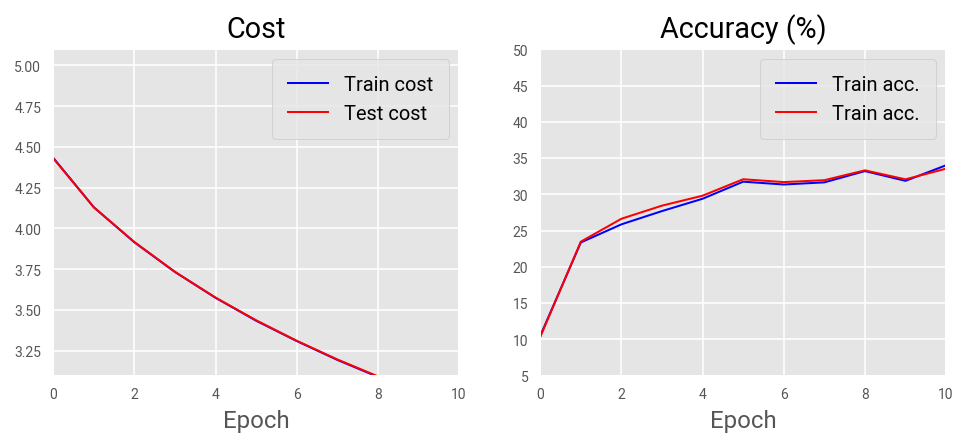

In [18]:
for epoch in range(n_epochs):
    # Shuffle the data:
    rng_state = np.random.get_state()
    np.random.shuffle(X_train)
    np.random.set_state(rng_state)
    np.random.shuffle(Y_train)
    np.random.set_state(rng_state)
    np.random.shuffle(y_train)
    
    print("-> Epoch =", epoch)
    for batch in range(round(N_train/n_batch)):
        X = X_train[batch*n_batch:(1+batch)*n_batch]
        Y = Y_train[batch*n_batch:(1+batch)*n_batch]
        
        # Forward pass:
        logits = np.dot(X, W.T) + b                 # Log probabilities = X*W + b   (KxN)
        exp_p = np.exp(logits - np.max(logits))     # To avoid NaN values being produced.
        probs = (exp_p.T / exp_p.sum(axis=1)).T     # Softmax function to get normalized probabilities. 
        
        # Backward pass:
        g = probs - Y                          # The error of prediction probs. Used to calculate gradients.
        # Calculating gradients:
        grad_W = np.dot(g.T, X) / n_batch      # Formula derived from the derivative chain rule for vectors.
        grad_b = np.dot(g.T, np.ones(n_batch)) / n_batch
        grad_W = grad_W + 2*lambd*W            # Adding the L2 regularization term.
        
        # Updating weights and bias:
        W = W - eta*grad_W
        b = b - eta*grad_b
        
    # Accuracy on training set:
    train_logits = np.dot(X_train, W.T) + b
    exp_p = np.exp(train_logits - np.max(train_logits))
    train_probs = (exp_p.T / np.sum(exp_p, axis=1)).T
    train_accuracy = 100 * len(np.where(np.argmax(train_probs, axis=1) == y_train)[0]) / y_train.shape[0]

    # Cost on training dataset:
    log_likelihood = -(np.inner(Y_train, np.log(train_probs)))    # Standard Loss = -Y * log(Predictions)
    log_likelihood = np.diag(log_likelihood)
    train_loss = np.sum(log_likelihood) / N_train
    train_cost = train_loss + lambd*(np.sum(W)**2)
    
    # Accuracy on test set:
    test_logits = np.dot(X_test, W.T) + b
    exp_p = np.exp(test_logits - np.max(test_logits))
    test_probs = (exp_p.T / np.sum(exp_p, axis=1)).T
    test_accuracy = 100 * len(np.where(np.argmax(test_probs, axis=1) == y_test)[0]) / y_test.shape[0]
    
    # Cost on test dataset:
    log_likelihood = -(np.inner(Y_test, np.log(test_probs)))    # Standard Loss = -Y * log(Predictions)
    log_likelihood = np.diag(log_likelihood)
    test_loss = np.sum(log_likelihood) / N_test
    test_cost = test_loss + lambd*(np.sum(W)**2)
    
    # Add it to lists:
    costs_train.append(train_cost)
    costs_test.append(test_cost)
    accs_train.append(train_accuracy)
    accs_test.append(test_accuracy)
    
    # Update plot:
    clear_output(wait=True)
    
    fig = plt.figure(1, figsize=(8,3))
    subplot1 = plt.subplot(121)
    subplot1.clear()
    subplot1.plot(costs_train, 'b-', label="Train cost")
    subplot1.plot(costs_test, 'r-', label="Test cost")
    subplot1.legend()
    subplot1.set_title("Cost")
    subplot1.set_xlabel("Epoch")
    plt.xlim(0, n_epochs)
    plt.ylim(0.75*costs_train[1], 1.15*costs_train[0])
    
    subplot2 = plt.subplot(122)
    subplot2.clear()
    subplot2.plot(accs_train, 'b-', label="Train acc.")
    subplot2.plot(accs_test, 'r-', label="Train acc.")
    subplot2.legend()
    subplot2.set_title("Accuracy (%)")
    subplot2.set_xlabel("Epoch")
    plt.xlim(0, n_epochs)
    plt.ylim(5, 50)
    
    plt.show()

In [19]:
print("Final accuracy on test dataset:", accs_test[-1], "%")

Final accuracy on test dataset: 33.55 %


## Visualizing the Class Templates
The weights (the W vector) visualized in an image (dims 32x32x3).

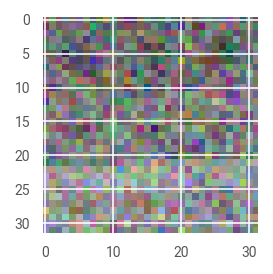

Class: airplane


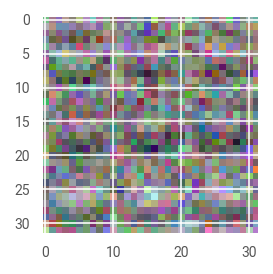

Class: automobile


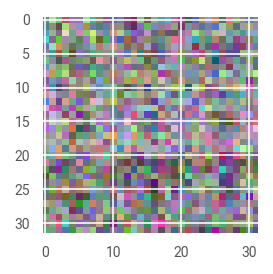

Class: bird


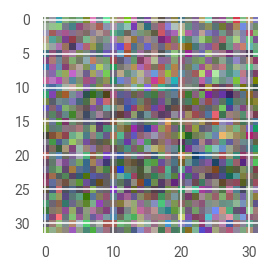

Class: cat


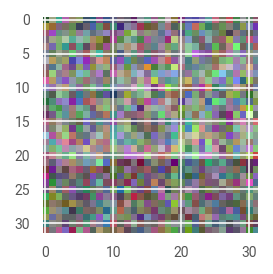

Class: deer


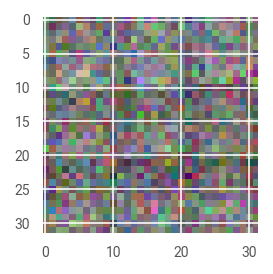

Class: dog


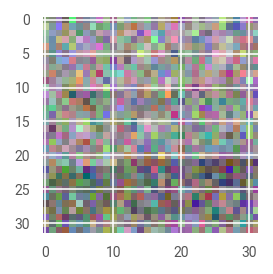

Class: frog


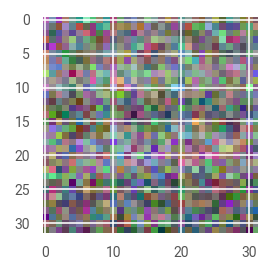

Class: horse


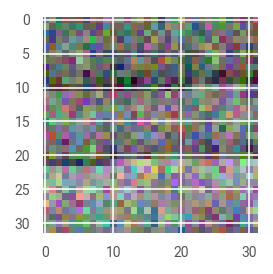

Class: ship


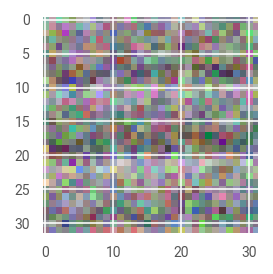

Class: truck


In [23]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i in range(W.shape[0]):
    W_class_template = np.reshape(W[i,:]*255, [32,32,3])
    W_class_template = (W_class_template - np.min(W_class_template)) / (np.max(W_class_template - np.min(W_class_template)))
    W_class_template2 = np.transpose(W_class_template, (1,0,2))  # Not sure if correct / needed.
    plt.figure(1, figsize=(2,2))
    plt.imshow(W_class_template)
    plt.show()
    print("Class:", classes[i])